In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch torchvision datasets
!pip install git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-bu

In [ ]:
from datasets import load_dataset
import clip
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
ds = load_dataset("aggr8/brain_mri_train_test_split")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/537 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/7.88M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/480 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/320 [00:00<?, ? examples/s]

In [ ]:
model, preprocess = clip.load("ViT-B/16", device = device, jit=False)

100%|███████████████████████████████████████| 335M/335M [00:03<00:00, 96.6MiB/s]


In [ ]:
text_prompts = ["a photo of glioma tumor", "a photo of meningioma tumor", "a photo of no tumor", "a photo of pituitary tumor"]

class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = preprocess(self.images[idx])
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


class CustomImageDatasetTrain(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = clip.tokenize([text_prompts[label] for label in labels])
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = preprocess(self.images[idx])
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

transformations = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])



In [ ]:
dataset = CustomImageDatasetTrain(ds["train"]["image"], ds["train"]["label"], transform=transformations)
train_dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

test_dataset = CustomImageDataset(ds["test"]["image"], ds["test"]["label"])
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

test_dataset_2 = CustomImageDataset(ds["train"]["image"], ds["train"]["label"])
test_dataloader_2 = DataLoader(test_dataset_2, batch_size=32, shuffle=False)

In [ ]:
import torch.nn as nn

# Modify the model to include a classifier for subcategories
class CLIPFineTuner(nn.Module):
    def __init__(self, model, num_classes):
        super(CLIPFineTuner, self).__init__()
        self.model = model
        self.classifier = nn.Linear(model.visual.output_dim, num_classes)

    def forward(self, x):
        with torch.no_grad():
            features = self.model.encode_image(x).float()  # Convert to float32
        return self.classifier(features)

In [ ]:
model_ft = CLIPFineTuner(model, 4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ft.parameters(), lr=1e-2)

In [ ]:
from tqdm import tqdm
import torch
import os

# Number of epochs for training
num_epochs = 100

best_accuracy = 0

best_model_path = "/content/drive/My Drive/Data/COL828/full_finetune_model_1.pth"

train_acc = []
test_acc = []
epoches = []
train_loss = []
test_loss = []
prev_train_acc = prev_test_acc = prev_train_loss = prev_test_loss = None

# Training loop
for epoch in range(num_epochs):
    model_ft.train()
    running_loss = 0.0
    pbar = tqdm(test_dataloader_2, desc=f"Epoch {epoch+1}/{num_epochs}, Loss: 0.0000")

    pred_label = []
    true_label = []

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)  # Move images and labels to the device (GPU or CPU)
        optimizer.zero_grad()  # Clear the gradients of all optimized variables
        outputs = model_ft(images)  # Forward pass: compute predicted outputs by passing inputs to the model

        # Update pred_label and true_label
        _, predicted = torch.max(outputs.data, 1)  # Get the predicted class
        pred_label.extend(predicted.cpu().numpy())  # Store predictions
        true_label.extend(labels.cpu().numpy())  # Store true labels

        loss = criterion(outputs, labels)  # Calculate the loss
        loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  # Perform a single optimization step (parameter update)

        running_loss += loss.item()  # Update running loss
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(test_dataloader_2):.4f}")  # Update progress bar with current loss

    # Calculate and print training accuracy
    train_correct = sum(p == t for p, t in zip(pred_label, true_label))
    train_accuracy = 100 * train_correct / len(true_label)
    train_acc.append(train_accuracy)
    epoches.append(epoch + 1)
    train_loss.append(running_loss/len(test_dataloader_2))

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(test_dataloader_2):.4f}, Training Accuracy: {train_accuracy:.2f}%')

    # Validation
    model_ft.eval()  # Set the model to evaluation mode
    correct = 0  # Initialize correct predictions counter
    total = 0  # Initialize total samples counter
    running_loss_test = 0
    with torch.no_grad():  # Disable gradient calculation for validation
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)  # Move images and labels to the device
            outputs = model_ft(images)  # Forward pass: compute predicted outputs by passing inputs to the model
            _, predicted = torch.max(outputs.data, 1)  # Get the class label with the highest probability
            total += labels.size(0)  # Update total samples
            correct += (predicted == labels).sum().item()  # Update correct predictions
            loss = criterion(outputs, labels)  # Calculate the loss
            running_loss_test += loss.item()  # Update running loss

    accuracy_test = 100 * correct / total
    test_acc.append(accuracy_test)
    test_loss.append(running_loss_test/len(test_dataloader))

    print(f'Validation Accuracy: {accuracy_test:.2f}%')  # Print validation accuracy for the epoch

    # Calculate convergence speed
    if prev_train_acc is not None:
        acc_conv_speed_train = train_accuracy - prev_train_acc
        acc_conv_speed_test = accuracy_test - prev_test_acc
        loss_conv_speed_train = prev_train_loss - train_loss[-1]
        loss_conv_speed_test = prev_test_loss - test_loss[-1]

        print(f'Convergence Speed - Training Accuracy: {acc_conv_speed_train:.4f}, Validation Accuracy: {acc_conv_speed_test:.4f}')
        print(f'Convergence Speed - Training Loss: {loss_conv_speed_train:.4f}, Validation Loss: {loss_conv_speed_test:.4f}')

    # Update previous epoch values
    prev_train_acc, prev_test_acc = train_accuracy, accuracy_test
    prev_train_loss, prev_test_loss = train_loss[-1], test_loss[-1]

    # Save best model if the validation accuracy improves
    if accuracy_test > best_accuracy:
        best_accuracy = accuracy_test
        os.makedirs( "/content/drive/My Drive/Data/COL828", exist_ok=True)
        torch.save(model_ft.state_dict(), best_model_path)
        print(f"Best model saved with accuracy {best_accuracy:.2f}%")

# Save the fine-tuned model
torch.save(model_ft.state_dict(), 'clip_finetuned.pth')  # Save the model's state dictionary

# Optionally, you can visualize the accuracy over epochs
import matplotlib.pyplot as plt

plt.plot(epoches, train_acc, label='Training Accuracy')
plt.plot(epoches, test_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

# Plot loss curves
plt.plot(epoches, train_loss, label='Training Loss')
plt.plot(epoches, test_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


Epoch 1/100, Loss: 1.1672: 100%|██████████| 15/15 [00:05<00:00,  2.74it/s]


Epoch [1/100], Loss: 1.1672, Training Accuracy: 47.50%
Validation Accuracy: 69.06%
Best model saved with accuracy 69.06%


Epoch 2/100, Loss: 0.7280: 100%|██████████| 15/15 [00:03<00:00,  4.94it/s]


Epoch [2/100], Loss: 0.7280, Training Accuracy: 73.33%
Validation Accuracy: 76.56%
Convergence Speed - Training Accuracy: 25.8333, Validation Accuracy: 7.5000
Convergence Speed - Training Loss: 0.4392, Validation Loss: 0.1722
Best model saved with accuracy 76.56%


Epoch 3/100, Loss: 0.5916: 100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


Epoch [3/100], Loss: 0.5916, Training Accuracy: 80.42%
Validation Accuracy: 82.19%
Convergence Speed - Training Accuracy: 7.0833, Validation Accuracy: 5.6250
Convergence Speed - Training Loss: 0.1364, Validation Loss: 0.1296
Best model saved with accuracy 82.19%


Epoch 4/100, Loss: 0.5030: 100%|██████████| 15/15 [00:03<00:00,  4.48it/s]


Epoch [4/100], Loss: 0.5030, Training Accuracy: 84.58%
Validation Accuracy: 85.00%
Convergence Speed - Training Accuracy: 4.1667, Validation Accuracy: 2.8125
Convergence Speed - Training Loss: 0.0885, Validation Loss: 0.0783
Best model saved with accuracy 85.00%


Epoch 5/100, Loss: 0.4390: 100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


Epoch [5/100], Loss: 0.4390, Training Accuracy: 86.88%
Validation Accuracy: 85.31%
Convergence Speed - Training Accuracy: 2.2917, Validation Accuracy: 0.3125
Convergence Speed - Training Loss: 0.0640, Validation Loss: 0.0389
Best model saved with accuracy 85.31%


Epoch 6/100, Loss: 0.3946: 100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


Epoch [6/100], Loss: 0.3946, Training Accuracy: 87.71%
Validation Accuracy: 85.62%
Convergence Speed - Training Accuracy: 0.8333, Validation Accuracy: 0.3125
Convergence Speed - Training Loss: 0.0445, Validation Loss: 0.0242
Best model saved with accuracy 85.62%


Epoch 7/100, Loss: 0.3624: 100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


Epoch [7/100], Loss: 0.3624, Training Accuracy: 89.38%
Validation Accuracy: 87.19%
Convergence Speed - Training Accuracy: 1.6667, Validation Accuracy: 1.5625
Convergence Speed - Training Loss: 0.0321, Validation Loss: 0.0182
Best model saved with accuracy 87.19%


Epoch 8/100, Loss: 0.3372: 100%|██████████| 15/15 [00:03<00:00,  4.95it/s]


Epoch [8/100], Loss: 0.3372, Training Accuracy: 90.00%
Validation Accuracy: 87.19%
Convergence Speed - Training Accuracy: 0.6250, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0253, Validation Loss: 0.0151


Epoch 9/100, Loss: 0.3159: 100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


Epoch [9/100], Loss: 0.3159, Training Accuracy: 90.21%
Validation Accuracy: 87.19%
Convergence Speed - Training Accuracy: 0.2083, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0212, Validation Loss: 0.0130


Epoch 10/100, Loss: 0.2976: 100%|██████████| 15/15 [00:03<00:00,  4.63it/s]


Epoch [10/100], Loss: 0.2976, Training Accuracy: 91.25%
Validation Accuracy: 87.50%
Convergence Speed - Training Accuracy: 1.0417, Validation Accuracy: 0.3125
Convergence Speed - Training Loss: 0.0183, Validation Loss: 0.0112
Best model saved with accuracy 87.50%


Epoch 11/100, Loss: 0.2819: 100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


Epoch [11/100], Loss: 0.2819, Training Accuracy: 91.25%
Validation Accuracy: 88.44%
Convergence Speed - Training Accuracy: 0.0000, Validation Accuracy: 0.9375
Convergence Speed - Training Loss: 0.0158, Validation Loss: 0.0097
Best model saved with accuracy 88.44%


Epoch 12/100, Loss: 0.2683: 100%|██████████| 15/15 [00:03<00:00,  4.87it/s]


Epoch [12/100], Loss: 0.2683, Training Accuracy: 91.67%
Validation Accuracy: 88.44%
Convergence Speed - Training Accuracy: 0.4167, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0135, Validation Loss: 0.0086


Epoch 13/100, Loss: 0.2567: 100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


Epoch [13/100], Loss: 0.2567, Training Accuracy: 92.29%
Validation Accuracy: 88.75%
Convergence Speed - Training Accuracy: 0.6250, Validation Accuracy: 0.3125
Convergence Speed - Training Loss: 0.0117, Validation Loss: 0.0076
Best model saved with accuracy 88.75%


Epoch 14/100, Loss: 0.2464: 100%|██████████| 15/15 [00:03<00:00,  4.87it/s]


Epoch [14/100], Loss: 0.2464, Training Accuracy: 92.71%
Validation Accuracy: 89.69%
Convergence Speed - Training Accuracy: 0.4167, Validation Accuracy: 0.9375
Convergence Speed - Training Loss: 0.0103, Validation Loss: 0.0065
Best model saved with accuracy 89.69%


Epoch 15/100, Loss: 0.2371: 100%|██████████| 15/15 [00:03<00:00,  4.67it/s]


Epoch [15/100], Loss: 0.2371, Training Accuracy: 93.12%
Validation Accuracy: 89.69%
Convergence Speed - Training Accuracy: 0.4167, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0093, Validation Loss: 0.0048


Epoch 16/100, Loss: 0.2285: 100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


Epoch [16/100], Loss: 0.2285, Training Accuracy: 93.54%
Validation Accuracy: 89.69%
Convergence Speed - Training Accuracy: 0.4167, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0087, Validation Loss: 0.0021


Epoch 17/100, Loss: 0.2200: 100%|██████████| 15/15 [00:03<00:00,  4.98it/s]


Epoch [17/100], Loss: 0.2200, Training Accuracy: 93.75%
Validation Accuracy: 89.69%
Convergence Speed - Training Accuracy: 0.2083, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0084, Validation Loss: -0.0013


Epoch 18/100, Loss: 0.2117: 100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


Epoch [18/100], Loss: 0.2117, Training Accuracy: 93.33%
Validation Accuracy: 89.38%
Convergence Speed - Training Accuracy: -0.4167, Validation Accuracy: -0.3125
Convergence Speed - Training Loss: 0.0083, Validation Loss: -0.0047


Epoch 19/100, Loss: 0.2036: 100%|██████████| 15/15 [00:03<00:00,  4.95it/s]


Epoch [19/100], Loss: 0.2036, Training Accuracy: 93.96%
Validation Accuracy: 88.12%
Convergence Speed - Training Accuracy: 0.6250, Validation Accuracy: -1.2500
Convergence Speed - Training Loss: 0.0082, Validation Loss: -0.0071


Epoch 20/100, Loss: 0.1957: 100%|██████████| 15/15 [00:03<00:00,  4.84it/s]


Epoch [20/100], Loss: 0.1957, Training Accuracy: 94.17%
Validation Accuracy: 87.19%
Convergence Speed - Training Accuracy: 0.2083, Validation Accuracy: -0.9375
Convergence Speed - Training Loss: 0.0079, Validation Loss: -0.0074


Epoch 21/100, Loss: 0.1882: 100%|██████████| 15/15 [00:03<00:00,  4.49it/s]


Epoch [21/100], Loss: 0.1882, Training Accuracy: 95.00%
Validation Accuracy: 87.19%
Convergence Speed - Training Accuracy: 0.8333, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0075, Validation Loss: -0.0059


Epoch 22/100, Loss: 0.1811: 100%|██████████| 15/15 [00:02<00:00,  5.03it/s]


Epoch [22/100], Loss: 0.1811, Training Accuracy: 95.42%
Validation Accuracy: 87.19%
Convergence Speed - Training Accuracy: 0.4167, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0071, Validation Loss: -0.0035


Epoch 23/100, Loss: 0.1745: 100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


Epoch [23/100], Loss: 0.1745, Training Accuracy: 95.83%
Validation Accuracy: 87.81%
Convergence Speed - Training Accuracy: 0.4167, Validation Accuracy: 0.6250
Convergence Speed - Training Loss: 0.0067, Validation Loss: -0.0015


Epoch 24/100, Loss: 0.1682: 100%|██████████| 15/15 [00:03<00:00,  4.95it/s]


Epoch [24/100], Loss: 0.1682, Training Accuracy: 96.04%
Validation Accuracy: 87.81%
Convergence Speed - Training Accuracy: 0.2083, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0062, Validation Loss: -0.0003


Epoch 25/100, Loss: 0.1624: 100%|██████████| 15/15 [00:03<00:00,  4.99it/s]


Epoch [25/100], Loss: 0.1624, Training Accuracy: 96.04%
Validation Accuracy: 87.81%
Convergence Speed - Training Accuracy: 0.0000, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0058, Validation Loss: 0.0001


Epoch 26/100, Loss: 0.1571: 100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


Epoch [26/100], Loss: 0.1571, Training Accuracy: 96.46%
Validation Accuracy: 87.50%
Convergence Speed - Training Accuracy: 0.4167, Validation Accuracy: -0.3125
Convergence Speed - Training Loss: 0.0053, Validation Loss: -0.0001


Epoch 27/100, Loss: 0.1524: 100%|██████████| 15/15 [00:03<00:00,  4.89it/s]


Epoch [27/100], Loss: 0.1524, Training Accuracy: 96.46%
Validation Accuracy: 87.19%
Convergence Speed - Training Accuracy: 0.0000, Validation Accuracy: -0.3125
Convergence Speed - Training Loss: 0.0047, Validation Loss: -0.0004


Epoch 28/100, Loss: 0.1482: 100%|██████████| 15/15 [00:04<00:00,  3.39it/s]


Epoch [28/100], Loss: 0.1482, Training Accuracy: 96.46%
Validation Accuracy: 87.19%
Convergence Speed - Training Accuracy: 0.0000, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0042, Validation Loss: -0.0006


Epoch 29/100, Loss: 0.1445: 100%|██████████| 15/15 [00:03<00:00,  4.90it/s]


Epoch [29/100], Loss: 0.1445, Training Accuracy: 96.88%
Validation Accuracy: 87.19%
Convergence Speed - Training Accuracy: 0.4167, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0037, Validation Loss: -0.0007


Epoch 30/100, Loss: 0.1413: 100%|██████████| 15/15 [00:03<00:00,  5.00it/s]


Epoch [30/100], Loss: 0.1413, Training Accuracy: 96.88%
Validation Accuracy: 87.19%
Convergence Speed - Training Accuracy: 0.0000, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0032, Validation Loss: -0.0005


Epoch 31/100, Loss: 0.1385: 100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


Epoch [31/100], Loss: 0.1385, Training Accuracy: 96.88%
Validation Accuracy: 87.50%
Convergence Speed - Training Accuracy: 0.0000, Validation Accuracy: 0.3125
Convergence Speed - Training Loss: 0.0028, Validation Loss: 0.0001


Epoch 32/100, Loss: 0.1361: 100%|██████████| 15/15 [00:03<00:00,  4.92it/s]


Epoch [32/100], Loss: 0.1361, Training Accuracy: 97.29%
Validation Accuracy: 87.81%
Convergence Speed - Training Accuracy: 0.4167, Validation Accuracy: 0.3125
Convergence Speed - Training Loss: 0.0024, Validation Loss: 0.0010


Epoch 33/100, Loss: 0.1339: 100%|██████████| 15/15 [00:03<00:00,  4.72it/s]


Epoch [33/100], Loss: 0.1339, Training Accuracy: 97.50%
Validation Accuracy: 87.81%
Convergence Speed - Training Accuracy: 0.2083, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0022, Validation Loss: 0.0022


Epoch 34/100, Loss: 0.1320: 100%|██████████| 15/15 [00:03<00:00,  4.87it/s]


Epoch [34/100], Loss: 0.1320, Training Accuracy: 97.50%
Validation Accuracy: 87.81%
Convergence Speed - Training Accuracy: 0.0000, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0019, Validation Loss: 0.0038


Epoch 35/100, Loss: 0.1302: 100%|██████████| 15/15 [00:03<00:00,  4.90it/s]


Epoch [35/100], Loss: 0.1302, Training Accuracy: 97.29%
Validation Accuracy: 87.81%
Convergence Speed - Training Accuracy: -0.2083, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0018, Validation Loss: 0.0057


Epoch 36/100, Loss: 0.1284: 100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


Epoch [36/100], Loss: 0.1284, Training Accuracy: 97.29%
Validation Accuracy: 87.81%
Convergence Speed - Training Accuracy: 0.0000, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0018, Validation Loss: 0.0076


Epoch 37/100, Loss: 0.1265: 100%|██████████| 15/15 [00:03<00:00,  4.89it/s]


Epoch [37/100], Loss: 0.1265, Training Accuracy: 97.50%
Validation Accuracy: 88.12%
Convergence Speed - Training Accuracy: 0.2083, Validation Accuracy: 0.3125
Convergence Speed - Training Loss: 0.0019, Validation Loss: 0.0095


Epoch 38/100, Loss: 0.1244: 100%|██████████| 15/15 [00:03<00:00,  4.82it/s]


Epoch [38/100], Loss: 0.1244, Training Accuracy: 97.29%
Validation Accuracy: 89.06%
Convergence Speed - Training Accuracy: -0.2083, Validation Accuracy: 0.9375
Convergence Speed - Training Loss: 0.0021, Validation Loss: 0.0111


Epoch 39/100, Loss: 0.0877:  73%|███████▎  | 11/15 [00:02<00:00,  4.34it/s]


KeyboardInterrupt: 

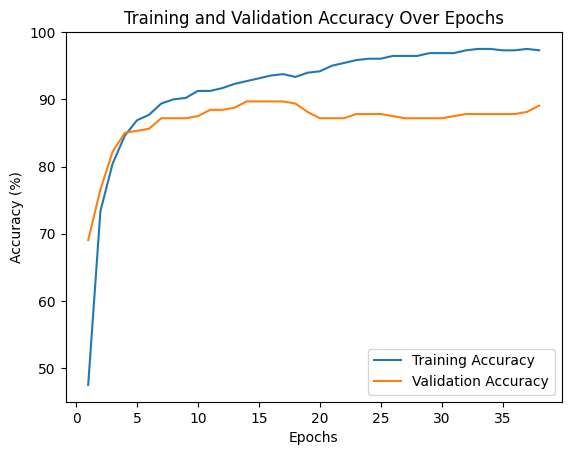

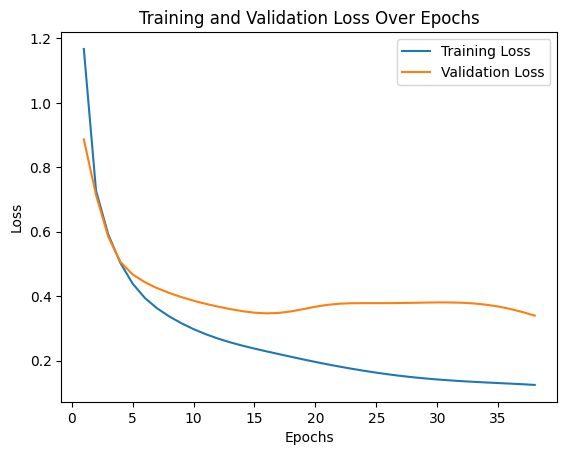

In [ ]:
import matplotlib.pyplot as plt

plt.plot(epoches, train_acc, label='Training Accuracy')
plt.plot(epoches, test_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

# Plot loss curves
plt.plot(epoches, train_loss, label='Training Loss')
plt.plot(epoches, test_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()